import numpy as np
import pandas as pd
import sys
import re
import time
import datetime
from time import time, gmtime, strftime
from datetime import datetime
import statistics
from tqdm import tqdm_notebook as tqdm
from __future__ import division
from collections import Counter
from gensim import models
import gensim, logging
from gensim.models import Word2Vec
import pickle
import seaborn as sns
from copy import deepcopy

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, LeavePOut
from sklearn.linear_model import LogisticRegression, ElasticNet, SGDClassifier, LogisticRegressionCV, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc, mutual_info_score, average_precision_score, precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize as tokenizer
import jellyfish
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell # no need of print for several objects!!!
InteractiveShell.ast_node_interactivity = "all"

#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

%matplotlib inline

init_vec = True

2 possibilities:
- Load and merge samples and labels.
- Load pre-built dataset.

(go to either of them with Ctrl+F)

#### Load and merge samples and labels.

In [2]:
path = '/media/hdd/salaun/wikiedit/annotations/data_v1/'

file_list = ['00_09_42',
             '00_09_73',
             '10_19_42',
             '20_24_42',
             '25_29_42',
             '30_34_42',
             '35_39_42',
             '40_44_42_uniq_parag',
             '40_44_42',
             '40_44_73',
             '45_49_42',
             '45_49_73',
             '50_54_42',
             '50_54_73',
             '55_59_42',
             '55_59_73',
             '60_65_42',
             '66-69_72_42',
             '66-69_72_73'
              ]

df_sample = pd.concat([pd.read_csv(path + file + '_sample.tsv', sep="\t") for file in file_list], ignore_index=True)
df_post_annot = pd.concat([pd.read_csv(path + file + '_post_annot_S.csv', sep=';', header=None) for file in file_list], ignore_index=True)
df_post_annot.columns = ['index', 'sample_id', 'raw_annot']

print('Number of files:', len(file_list))
df_sample.shape
df_post_annot.shape

Number of files: 19


(1900, 35)

(1900, 3)

In [3]:
# get dummies
print('Length df_sample:', len(df_sample))
print('Length df_post_annot:', len(df_post_annot))

labels_lists = ['ortho_gram_typo','wiki_formatting', 'vandal', 'reordering', 
              'revert_vandal', 'revert_other', 'content_remove', 'content_add',
              'nbr_wr', 'nbr_rw', 'nbr_x', 
              'semant_simil', 'semant_diff', 
              'other']

gross_labels_list = ['semant', 'nbr', 'semant_or_nbr']

for label in labels_lists:
    df_post_annot[label] = df_post_annot.raw_annot.str.contains(label)


for label in gross_labels_list: #initialization
    df_post_annot[label] = False


for i in range(0, df_post_annot.shape[0]):
    
    if df_post_annot.semant_simil.iloc[i] or df_post_annot.semant_diff.iloc[i]:
        df_post_annot.loc[i,'semant'] = True

    if df_post_annot.nbr_wr.iloc[i] or df_post_annot.nbr_rw.iloc[i] or df_post_annot.nbr_x.iloc[i]:
        df_post_annot.loc[i,'nbr'] = True

    if df_post_annot.semant.iloc[i]==True or df_post_annot.nbr.iloc[i]==True:
        df_post_annot.loc[i,'semant_or_nbr'] = True

df_sample.shape
df_post_annot.shape

Length df_sample: 1900
Length df_post_annot: 1900


(1900, 35)

(1900, 20)

In [4]:
print("DISTRIBUTION OF LABELS OVER ALL ANNOTATIONS \n")

df_annot_distrib = pd.DataFrame(index=labels_lists, columns=['absolute number', 'share of all observations'])
df_annot_distrib_bis = pd.DataFrame(index=gross_labels_list, columns=['absolute number', 'share of all observations'])

for label in labels_lists:
    df_annot_distrib.loc[label,'absolute number'] = (df_post_annot[label]==1).sum()
    df_annot_distrib.loc[label,'share of all observations'] = 100*((df_post_annot[label]==1).sum())/len(df_post_annot)
df_annot_distrib 
    
for label in gross_labels_list:
    df_annot_distrib_bis.loc[label,'absolute number'] = (df_post_annot[label]==1).sum()
    df_annot_distrib_bis.loc[label,'share of all observations'] = 100*((df_post_annot[label]==1).sum())/len(df_post_annot)
df_annot_distrib_bis   

DISTRIBUTION OF LABELS OVER ALL ANNOTATIONS 



,absolute number,share of all observations
ortho_gram_typo,506,26.6316
wiki_formatting,696,36.6316
vandal,114,6
reordering,91,4.78947
revert_vandal,12,0.631579
revert_other,6,0.315789
content_remove,116,6.10526
content_add,477,25.1053
nbr_wr,39,2.05263
nbr_rw,7,0.368421


,absolute number,share of all observations
semant,355,18.6842
nbr,48,2.52632
semant_or_nbr,403,21.2105


In [5]:
df_XY = pd.concat([df_sample, df_post_annot.loc[:,'raw_annot':'semant_or_nbr']], axis=1)
df_XY.shape
df_XY.columns
df_XY = df_XY.fillna('')
df_XY.tail(2)

(1900, 53)

Index(['Unnamed: 0', 'comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'modif', 'modif_add', 'modif_remove', 'parentid', 'registered',
       'sample_id', 'timestamp', 'title', 'user_id', 'username', 'raw_annot',
       'ortho_gram_typo', 'wiki_formatting', 'vandal', 'reordering',
       'revert_vandal', 'revert_other', 'content_remove', 'content_add',
       'nbr_wr', 'nbr_rw', 'nbr_x', 'semant_simil', 'semant_diff', 'other',
       'semant', 'nbr', 'semant_or_nbr'],
      dtype='object')

,Unnamed: 0,comment,filt_bot,filt_coher,filt_confli,filt_contradic,filt_erreur,filt_erron,filt_faux,filt_frappe,filt_gramma,filt_ortho,filt_revert,filt_sens,filt_tromp,filt_typo,filt_vandalisme,filt_vraise,format,id,id_file,id_modif,label_incoherence,minor,model,modif,modif_add,modif_remove,parentid,registered,sample_id,timestamp,title,user_id,username,raw_annot,ortho_gram_typo,wiki_formatting,vandal,reordering,revert_vandal,revert_other,content_remove,content_add,nbr_wr,nbr_rw,nbr_x,semant_simil,semant_diff,other,semant,nbr,semant_or_nbr
1898,98,,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,95886840,p5847438p6039053,1279779,False,False,wikitext,"- '''Michael Loewe''', de son vrai nom Mihai L...","'''Michael Loewe''', de son vrai nom Mihai Leu...","'''Michael Loewe''', de son vrai nom Mihai Leu...",95886829.0,True,p5847438p6039053_1279779,2013-08-17T21:34:39Z,Michael Loewe,31767,Skblzz1,ortho_gram_typo,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1899,99,/* Synopsis */,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,74105978,p5847438p6039053,1046153,False,False,wikitext,- Un homme et deux femmes se mettent à table. ...,Un homme et deux femmes se mettent à table. Au...,Un homme et deux femmes se mettent à table. Au...,74105972.0,True,p5847438p6039053_1046153,2012-01-09T02:18:33Z,Le Repas fantastique,418936,Celette,ortho_gram_typo,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


#### Load pre-built dataset.

In [6]:
#df_XY.to_csv(path + 'full_dataset_with_all_labels.tsv', sep='\t')

In [7]:
path = '/media/hdd/salaun/wikiedit/annotations/data_v1/'
df_XY = pd.read_csv(path + 'full_dataset_with_all_labels.tsv', sep='\t')
df_XY.columns
df_XY = df_XY.loc[:,'comment':'semant_or_nbr']
df_XY.shape

Index(['Unnamed: 0', 'Unnamed: 0.1', 'comment', 'filt_bot', 'filt_coher',
       'filt_confli', 'filt_contradic', 'filt_erreur', 'filt_erron',
       'filt_faux', 'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert',
       'filt_sens', 'filt_tromp', 'filt_typo', 'filt_vandalisme',
       'filt_vraise', 'format', 'id', 'id_file', 'id_modif',
       'label_incoherence', 'minor', 'model', 'modif', 'modif_add',
       'modif_remove', 'parentid', 'registered', 'sample_id', 'timestamp',
       'title', 'user_id', 'username', 'raw_annot', 'ortho_gram_typo',
       'wiki_formatting', 'vandal', 'reordering', 'revert_vandal',
       'revert_other', 'content_remove', 'content_add', 'nbr_wr', 'nbr_rw',
       'nbr_x', 'semant_simil', 'semant_diff', 'other', 'semant', 'nbr',
       'semant_or_nbr'],
      dtype='object')

(1900, 52)

#### Merge samples and labels.

Concentrate **"incoherent"** samples that are the strings in ***modif_remove*** in pairs labeled as ***semant_diff***

In [8]:
df_incoher = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'modif_remove',
       'parentid', 'registered',
       'sample_id', 'timestamp', 'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_diff].copy()
df_incoher = df_incoher.reset_index()
df_incoher = df_incoher.rename(columns = {'modif_remove':'string'})
df_incoher = pd.concat([df_incoher, pd.DataFrame({'incoherence':1}, index=df_incoher.index)], axis=1)

concentrate **"coherent"** samples that are the strings in ***modif_add*** for pairs labeled as ***semant_diff*** (not included in the dataset this time)
and that are the strings in ***modif_\**** for pairs labeled as ***semant_simil***

/!\ We exclude the "rectified version" of incoherent samples, meaning ***modif_add*** in ***semant_diff*** pairs.

In [9]:
'''
df_coher1 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron',
                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', 
                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
                             'modif_add',
                             'parentid', 'registered','sample_id', 'timestamp', 
                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_diff].copy()
df_coher1 = df_coher1.rename(columns = {'modif_add':'string'})
'''
df_coher2 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron', 
                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', 
                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
                             'modif_remove',
                             'parentid', 'registered','sample_id', 'timestamp', 
                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_simil].copy()
df_coher2 = df_coher2.rename(columns = {'modif_remove':'string'})

df_coher3 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron', 
                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', 
                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
                             'modif_add',
                             'parentid', 'registered','sample_id', 'timestamp', 
                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_simil].copy()
df_coher3 = df_coher3.rename(columns = {'modif_add':'string'})

df_coher = pd.concat([#df_coher1,
                      df_coher2,
                      df_coher3],
                     axis = 0)

df_coher = df_coher.reset_index()

df_coher = pd.concat([df_coher, pd.DataFrame({'incoherence': 0}, index=df_coher.index)], axis=1)
#df_coher.columns = ['index', 'string', 'incoherence']

df = pd.concat([df_incoher, df_coher], axis=0, ignore_index=True)

"\ndf_coher1 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron',\n                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', \n                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',\n                             'modif_add',\n                             'parentid', 'registered','sample_id', 'timestamp', \n                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_diff].copy()\ndf_coher1 = df_coher1.rename(columns = {'modif_add':'string'})\n"

Check homogeneity of each label group

In [10]:
df_incoher.incoherence.value_counts() # check if y_test == incoherence
df_coher.incoherence.value_counts()

1    143
Name: incoherence, dtype: int64

0    424
Name: incoherence, dtype: int64

In [11]:
df.incoherence.value_counts()
df.incoherence.value_counts(normalize=True)

0    424
1    143
Name: incoherence, dtype: int64

0    0.747795
1    0.252205
Name: incoherence, dtype: float64

In [12]:
df.shape
df.columns
df.tail(2)

(567, 35)

Index(['index', 'comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'string', 'parentid', 'registered', 'sample_id', 'timestamp', 'title',
       'user_id', 'username', 'raw_annot', 'incoherence'],
      dtype='object')

,index,comment,filt_bot,filt_coher,filt_confli,filt_contradic,filt_erreur,filt_erron,filt_faux,filt_frappe,filt_gramma,filt_ortho,filt_revert,filt_sens,filt_tromp,filt_typo,filt_vandalisme,filt_vraise,format,id,id_file,id_modif,label_incoherence,minor,model,string,parentid,registered,sample_id,timestamp,title,user_id,username,raw_annot,incoherence
565,1893,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,34365984,p5847438p6039053,972379,False,False,wikitext,'''Oujda''' ([[arabe]] : ''wajda'' وجدة) est l...,34365556.0,True,p5847438p6039053_972379,2008-10-15T12:30:00Z,Oujda,210682.0,Barçawi,"wiki_formatting, content_add, semant_simil",0
566,1894,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,79013537,p5847438p6039053,1357657,False,False,wikitext,L'écartement des rails est 1000 mm et la tensi...,79013385.0,True,p5847438p6039053_1357657,2012-05-23T22:40:54Z,Tramway de Gand,584142.0,JG-Brill,"ortho_gram_typo, semant_simil",0


#### Filter editor-oriented text

In [13]:
string_pattern = '([a-zA-Z0-9ÀàÂâÆæÇçÈèÉéÊêËëÎîÏïÔôŒœÙùÛûÜü€₣]+|ref>|/ref>|\n\t|\'|[«».,\/#\|!$%\^&\*;:<>\[\]{}=\-_`~()])'

def wiki_normalize(s):
    s = re.sub(r'\[\[(?:[^\]|]*\|)?([^\]|]*)\]\]', r'\1', s.strip().lower())

    for element in [',', "pdf", "refnec", "référence nécessaire", "référence souhaitée", "..."]:
        s = s.replace("{{"+element+"}}","")
    s = re.sub(r'\{\{(?:[^\}|]*\|)?([^\}|]*)\}\}', r'\1', s.strip().lower())
    # remove {{ }} and remove {{a| from 

    #s = re.sub("\[[^\|]+\]", ' ', s.strip().lower())
    for element in ['\n', "'''''", "''''", "'''", "''"]:
        s = s.replace(element, " ")

    
    s = re.sub('<ref[^<]+</ref>', ' ', s) # https://stackoverflow.com/questions/12225729/regex-to-remove-text-between-tags-in-notepad
    

    s = re.sub('\{\{[^\|]+\|', ' ', s) # in {{a|b}} remove {{a| that is left ({{ and | are already removed)

    s = re.sub('<[^>]*>', ' ', s)
    s = re.sub('\[http[^\s]+\s', ' ', s)
    
    for element in ['|','{{', '}}', 'formatnum:','[...]', '[',']']:
        s = s.replace(element, " ")
        
    return s

def text_input_builder_bow(path):
    
    content = []
    i=0
    for line in open(path, "r+").readlines():   
        if not line.startswith('<') and not line.isspace():
            i+=1
            line = line.lower()
            line = wiki_normalize(line)
            line = re.findall(string_pattern, line) # turns line to list where all tokens are split
            line = " ".join(line) # all tokens are gathered in one string again with whitespaces as separators
            content.append(line)
        #if i == 400000:
        #    break
    return content

In [14]:
df.columns

Index(['index', 'comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'string', 'parentid', 'registered', 'sample_id', 'timestamp', 'title',
       'user_id', 'username', 'raw_annot', 'incoherence'],
      dtype='object')

#### Check string length character and token-wise

In [15]:
for i in range(0, len(df)):
    df.loc[i,'string'] = wiki_normalize(df.loc[i,'string'])
    df.loc[i,'len'] = len(df.loc[i,'string'])
    df.loc[i,'len_tok'] = len(re.findall(string_pattern, df.loc[i, 'string'].strip().lower()))
    
df[['len']].describe()
df[['len_tok']].describe()

,len
count,567.000000
mean,613.070547
std,642.704029
min,22.000000
25%,212.000000
50%,411.000000
75%,759.500000
max,4665.000000


,len_tok
count,567.000000
mean,123.754850
std,128.898849
min,6.000000
25%,43.000000
50%,83.000000
75%,155.000000
max,942.000000


#### Check homogeneity of length (character and token wise) between label groups

In [16]:
df[['len']][df.incoherence == 0].describe()
df[['len']][df.incoherence == 1].describe()

,len
count,424.000000
mean,648.660377
std,644.475441
min,27.000000
25%,215.750000
50%,429.500000
75%,865.250000
max,3997.000000


,len
count,143.000000
mean,507.545455
std,627.844858
min,22.000000
25%,179.500000
50%,366.000000
75%,584.500000
max,4665.000000


In [17]:
df[['len_tok']][df.incoherence == 0].describe()
df[['len_tok']][df.incoherence == 1].describe()

,len_tok
count,424.000000
mean,130.438679
std,129.270040
min,6.000000
25%,44.000000
50%,86.000000
75%,168.250000
max,815.000000


,len_tok
count,143.000000
mean,103.937063
std,126.164783
min,6.000000
25%,37.000000
50%,74.000000
75%,114.000000
max,942.000000


#### Character-length distribution

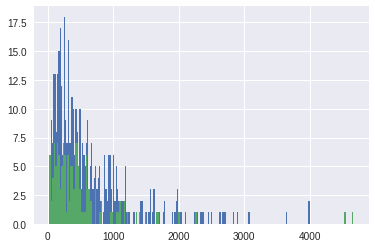

In [18]:
df[df.incoherence == 0].len.hist(bins=200)
df[df.incoherence == 1].len.hist(bins=200)

#### Token-length distribution

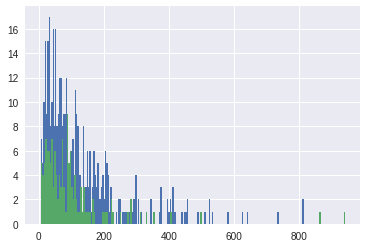

In [19]:
df[df.incoherence == 0].len_tok.hist(bins=200)
df[df.incoherence == 1].len_tok.hist(bins=200)

#### Language models (LM)

Run the cell below if the LM is not available (vector size = 100)

In [20]:
'''
#model100
#%%monitor_cell language_model_100

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'

content_input = text_input_builder_bow(path) # list where each sentence is a string

new_input = [string.split() for string in content_input] # list where each sentence is a list

#input_sentences must be list of lists of tokens
# https://rare-technologies.com/word2vec-tutorial/
model = Word2Vec(new_input, hs=1, negative=0)

#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')
'''

"\n#model100\n#%%monitor_cell language_model_100\n\nlogging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)\npath = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'\n\ncontent_input = text_input_builder_bow(path) # list where each sentence is a string\n\nnew_input = [string.split() for string in content_input] # list where each sentence is a list\n\n#input_sentences must be list of lists of tokens\n# https://rare-technologies.com/word2vec-tutorial/\nmodel = Word2Vec(new_input, hs=1, negative=0)\n\n#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')\n"

Load pre-defined model (vector size = 100)

In [21]:
# load the model again
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')

In [22]:
len(model.wv.vocab)

729651

Run the cell below if the LM is not available (vector size = 300)

In [23]:
'''
#model300
#%%monitor_cell language_model_300

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'

content_input = text_input_builder_bow(path) # list where each sentence is a string

new_input = [string.split() for string in content_input] # list where each sentence is a list

# input_sentences must be list of lists of tokens
# https://rare-technologies.com/word2vec-tutorial/
model = Word2Vec(new_input, size=300, hs=1, negative=0)

#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')
'''

"\n#model300\n#%%monitor_cell language_model_300\n\nlogging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)\npath = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'\n\ncontent_input = text_input_builder_bow(path) # list where each sentence is a string\n\nnew_input = [string.split() for string in content_input] # list where each sentence is a list\n\n# input_sentences must be list of lists of tokens\n# https://rare-technologies.com/word2vec-tutorial/\nmodel = Word2Vec(new_input, size=300, hs=1, negative=0)\n\n#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')\n"

Load pre-defined model (vector size = 300)

In [24]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')

## Split train/test 

In [29]:
df_train = df.sample(frac=0.8).copy()#,random_state=42)
df_test = df.drop(df_train.index).copy()
df_train = df_train.reset_index(drop=True).copy()
df_test = df_test.reset_index(drop=True).copy()
df_train = df_train.fillna('')
df_test = df_test.fillna('')

print('Distribution of labels in TRAIN set')
df_train.incoherence.value_counts()
df_train.incoherence.value_counts(normalize=True)
print('\n')
print('Distribution of labels in TEST set')
df_test.incoherence.value_counts()
df_test.incoherence.value_counts(normalize=True)

Distribution of labels in TRAIN set


0    346
1    108
Name: incoherence, dtype: int64

0    0.762115
1    0.237885
Name: incoherence, dtype: float64



Distribution of labels in TEST set


0    78
1    35
Name: incoherence, dtype: int64

0    0.690265
1    0.309735
Name: incoherence, dtype: float64

In [30]:
df_train.shape
df_test.shape

(454, 39)

(113, 39)

#### Functions

Choose either <code>cv_SKF</code>, <code>cv_RSKF</code> or <code>cv_LPO</code> for cross-validation setting.

In [31]:
cv_SKF = StratifiedKFold(n_splits=6, shuffle=True)
cv_RSKF = RepeatedStratifiedKFold(n_splits=6)
cv_LPO = LeavePOut(1)


def cross_val_series(X, y, clf, cv_input):
    
    metrics_list = ['precision', 'recall', 'f1', 'roc_auc'] #, 'neg_log_loss'
    df_scores = pd.DataFrame(index=metrics_list, columns=['score'])
    
    for metric in metrics_list:
        df_scores.loc[metric,'score'] = '{:.3f} (+/- {:.3f})'.format(cross_val_score(clf, X, y, cv=cv_input, scoring=metric).mean(), 1.96 * cross_val_score(clf, X, y, cv=cv_input, scoring=metric).std() / np.sqrt(len(cross_val_score(clf, X, y, cv=cv_input, scoring=metric))))
    return df_scores
    
    # roc_auc > needs to exceed 0.5
    # neg_log_loss > neg metric, needs to approach 0

Testing function.

In [32]:
def model_testing(X_train, y_train, X_test, y_test, model):
    
    metrics_list = ['precision', 'recall', 'f1', 'roc_auc']
    df_scores_test = pd.DataFrame(index=metrics_list, columns=['test_score'])
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    y_pred_proba = model.predict_proba(X_test)
    
    
    df_scores_test.loc['precision', 'test_score'] = '{:.3f}'.format(precision_score(y_test, y_pred))
    df_scores_test.loc['recall', 'test_score'] = '{:.3f}'.format(recall_score(y_test, y_pred))
    df_scores_test.loc['f1', 'test_score'] = '{:.3f}'.format(f1_score(y_test, y_pred))
    df_scores_test.loc['roc_auc', 'test_score'] = '{:.3f}'.format(roc_auc_score(y_test, y_pred_proba[:,1]))
    
    full_test_df = df_test.copy()
    full_test_df['y_test'] = pd.DataFrame(y_test)
    full_test_df['y_pred'] = pd.DataFrame(y_pred)
    full_test_df['y_pred_proba'] = pd.DataFrame(y_pred_proba[:,1])
    
    return df_scores_test, full_test_df, y_test, y_pred, y_pred_proba

Plot ROC curve.

In [33]:
def plot_roc_auc(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Method 1: BOW

Build new model (cell below) or load pre-existing model (next cell below)

In [34]:
%%time
#path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'
#txt_input = text_input_builder_bow(path)
#vectorizer = CountVectorizer(max_features=4096)
#vectorizer.fit(txt_input)
##pickle.dump(vectorizer, open("vectorizer_bow.p", "wb"))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.3 µs


In [35]:
vectorizer = pickle.load(open( "/home/dp/notebooks/vectorizer_bow.p", "rb" ))

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [36]:
print('Voc length: {:,}'.format(len(vectorizer.vocabulary_))) # max = 2,431,546

X_train = vectorizer.transform(df_train.string).toarray()
X_test = vectorizer.transform(df_test.string).toarray()

y_train = df_train.incoherence.values.copy()
y_test = df_test.incoherence.values.copy()

Voc length: 4,096


#### Dummy classifier

In [37]:
clf = DummyClassifier(strategy='uniform')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

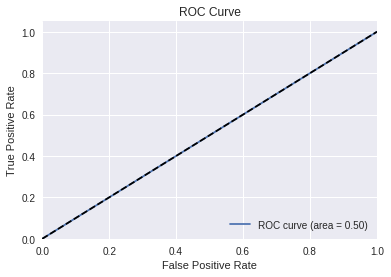

,score
precision,0.232 (+/- 0.029)
recall,0.509 (+/- 0.076)
f1,0.290 (+/- 0.045)
roc_auc,0.500 (+/- 0.000)


,test_score
precision,0.413
recall,0.743
f1,0.531
roc_auc,0.500


In [38]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

#### Logistic Regression classifier (best performance with string L2 regularization)

In [39]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.0000001)#, max_iter = 1000)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: Th

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The ma

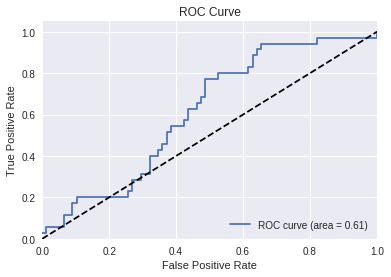

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.550 (+/- 0.050)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.614


In [40]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [41]:
logreg_bow_df = full_test_df.copy()

0    35
Name: y_pred, dtype: int64

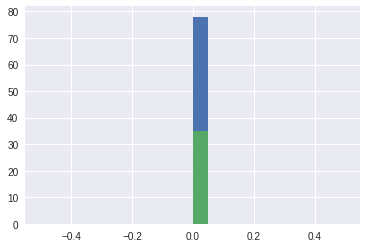

In [42]:
logreg_bow_df[logreg_bow_df.y_test == 0].y_pred.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

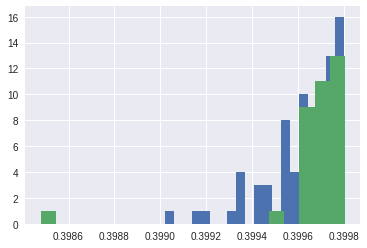

In [43]:
logreg_bow_df[logreg_bow_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred_proba.hist(bins=20)

In [44]:
logreg_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg_bow_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_bow_df.y_test == 1)&(logreg_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_bow_df.y_test == 1)&(logreg_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(logreg_bow_df.loc[i,'string'],'\n')
    
for id_subset in logreg_bow_df.sample_id[(logreg_bow_df.y_test == 1)&(logreg_bow_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
20,(depuis 2007) : vacant,1,1,0,0.399806,22.0,6.0
11,patrick cousot (né le 3 décembre 1948) est i...,1,1,0,0.399797,117.0,23.0
25,"très positionnel exploite de micro-avantages, ...",1,1,0,0.399783,69.0,14.0
24,"compte tenu de sa très forte notoriété, l'entr...",1,1,0,0.399778,90.0,20.0
10,le territoire communal est desservi par la lig...,1,1,0,0.399772,144.0,31.0
26,créé au lendemain de la seconde guerre mondial...,1,1,0,0.399771,387.0,69.0
13,le union atletico de maracaibo est un club d...,1,1,0,0.399769,86.0,15.0
8,"pour une nouvelle franchise, le jeu a réalisé ...",1,1,0,0.399756,171.0,38.0
28,"marilou est une fille belle, mais manipulatri...",1,1,0,0.399755,232.0,43.0
32,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.399754,187.0,43.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision Tree classifier

In [45]:
clf = DecisionTreeClassifier()#criterion='entropy', splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

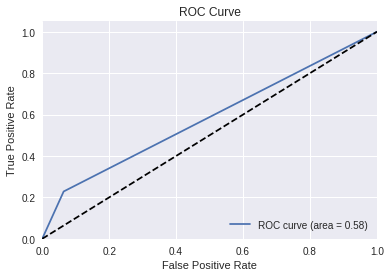

,score
precision,0.490 (+/- 0.131)
recall,0.176 (+/- 0.094)
f1,0.166 (+/- 0.088)
roc_auc,0.531 (+/- 0.050)


,test_score
precision,0.615
recall,0.229
f1,0.333
roc_auc,0.582


In [46]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [47]:
dt_bow_df = full_test_df.copy()

0    27
1     8
Name: y_pred, dtype: int64

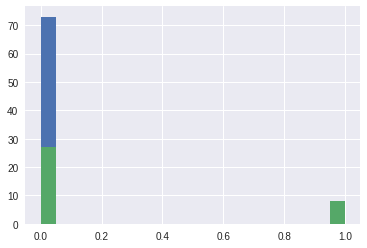

In [48]:
dt_bow_df[dt_bow_df.y_test == 0].y_pred.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

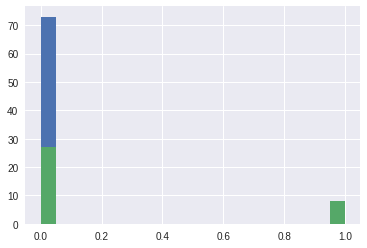

In [49]:
dt_bow_df[dt_bow_df.y_test == 0].y_pred_proba.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [50]:
dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt_bow_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(dt_bow_df.loc[i,'string'],'\n')
    
for id_subset in dt_bow_df.sample_id[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,on désigne par algorithmique ou algorithmie...,1,1,0,0.0,357.0,63.0
32,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.0,187.0,43.0
31,l'histoire politique est avant tout bien connu...,1,1,0,0.0,304.0,58.0
29,"dans ce cas de dressage, le dressage s’opère l...",1,1,0,0.0,1168.0,284.0
28,"marilou est une fille belle, mais manipulatri...",1,1,0,0.0,232.0,43.0
27,l alphabet de cumae est une variante occident...,1,1,0,0.0,441.0,95.0
26,créé au lendemain de la seconde guerre mondial...,1,1,0,0.0,387.0,69.0
25,"très positionnel exploite de micro-avantages, ...",1,1,0,0.0,69.0,14.0
24,"compte tenu de sa très forte notoriété, l'entr...",1,1,0,0.0,90.0,20.0
23,alles fühlt des liebe freuden (littéralement...,1,1,0,0.0,220.0,44.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
1,"le 29 mai 1958, rené coty appelle le général d...",1,1,1,1.0,4665.0,942.0
2,la tomate ( solanum lycopersicum l.) est un...,1,1,1,1.0,587.0,118.0
4,"en 2002, elle fait partie de la distribution d...",1,1,1,1.0,423.0,86.0
6,il est classé seizième meilleur film de tous l...,1,1,1,1.0,220.0,54.0
9,"cette institution, premier lycée de filles par...",1,1,1,1.0,655.0,129.0
15,l école des hautes études commerciales du nord...,1,1,1,1.0,738.0,140.0
19,bien qu'elles soient souvent négligées ou redo...,1,1,1,1.0,589.0,107.0
30,exemple le plus emblématique de l'orientalisme...,1,1,1,1.0,588.0,112.0


le 29 mai 1958, rené coty appelle le général de gaulle, suite aux mouvements insurrectionnels menés par des partisans de l'algérie française et des gaullistes, les deux étiquettes n'étant pas exclusives. le 4 juin 1958, le général crie à alger le fameux « je vous ai compris » . la foule comprenant des pieds noirs et des musulmans croyant à la magie de ces mots, crièrent « vive l'algérie française » tout en ovationnant le discours . le surlendemain 6 juin, il crie  «vive l'algérie française!»  à mostaganem. le 16 septembre 1959 le choc fut donc brutal pour tous les européens, qui se réveillent en entendant le général de gaulle parler d'autodétermination. à partir de ces circonstances joseph ortiz crée le puissant fnf (front national français), mouvement nationaliste et activiste. de nombreux autres groupuscules activistes naissent ou renaissent pour s'insurger contre ce qu'ils considèrent comme l'infamie et déshonneur gaullien. le 24 janvier 1960, début des barricades avec la participat

Mean length of detected positive scores (character-wise and token-wise)

In [51]:
dt_bow_df.len[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].mean()
dt_bow_df.len_tok[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].mean()

1058.125

211.0

#### Random forest

In [52]:
clf = RandomForestClassifier(n_estimators=2)#criterion='entropy', splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


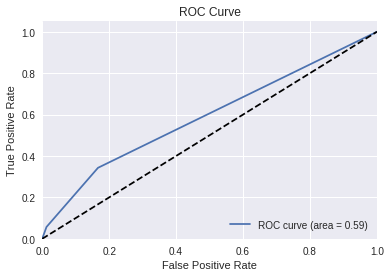

,score
precision,0.292 (+/- 0.294)
recall,0.028 (+/- 0.040)
f1,0.101 (+/- 0.070)
roc_auc,0.541 (+/- 0.031)


,test_score
precision,0.667
recall,0.057
f1,0.105
roc_auc,0.591


In [53]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [54]:
rf_bow_df = full_test_df.copy()

0    33
1     2
Name: y_pred, dtype: int64

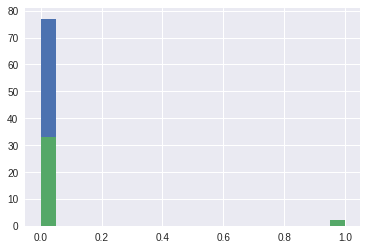

In [55]:
rf_bow_df[rf_bow_df.incoherence == 0].y_pred.hist(bins=20)
rf_bow_df[rf_bow_df.incoherence == 1].y_pred.hist(bins=20)
rf_bow_df[rf_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

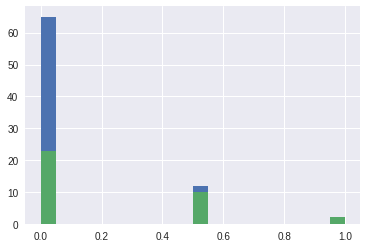

In [56]:
rf_bow_df[rf_bow_df.incoherence == 0].y_pred_proba.hist(bins=20)
rf_bow_df[rf_bow_df.incoherence == 1].y_pred_proba.hist(bins=20)

In [57]:
rf_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][rf_bow_df.y_test==1].sort_values('y_pred_proba', ascending=True)
rf_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = rf_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(rf_bow_df.loc[i,'string'],'\n')
    
for id_subset in rf_bow_df.sample_id[(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
17,"arrivé tardivement dans l'émission, ben effect...",1,1,0,0.0,509.0,109.0
23,alles fühlt des liebe freuden (littéralement...,1,1,0,0.0,220.0,44.0
22,"marth est une princesse de taille normale, ell...",1,1,0,0.0,413.0,88.0
21,de nombreux artistes importants ont participé ...,1,1,0,0.0,1049.0,207.0
20,(depuis 2007) : vacant,1,1,0,0.0,22.0,6.0
19,bien qu'elles soient souvent négligées ou redo...,1,1,0,0.0,589.0,107.0
18,"de 2006 à 2009, il conçoit et présente plusieu...",1,1,0,0.0,315.0,67.0
16,le toulouse blagnac hockey club est un club ...,1,1,0,0.0,237.0,50.0
14,"parmi les rescapés, le mieux préservé est le ...",1,1,0,0.0,261.0,61.0
13,le union atletico de maracaibo est un club d...,1,1,0,0.0,86.0,15.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,on désigne par algorithmique ou algorithmie...,1,1,1,1.0,357.0,63.0
29,"dans ce cas de dressage, le dressage s’opère l...",1,1,1,1.0,1168.0,284.0


on désigne par  algorithmique  ou  algorithmie  l'ensemble des activités logiques qui relèvent  des  algorithmes . le mot vient du nom du mathématicien perse al khuwarizmi, qui, au ixe siècle écrivit le premier ouvrage systématique sur la solution des équations linéaires et quadratiques. dans le cas général, l'algorithmique s'effectue au moyen de calculs. 

dans ce cas de dressage, le dressage s’opère le plus souvent dans la souffrance, cela peut générer une anxiété et un stress sur l'animal. en outre, les savoirs acquis ne sont pas généralisables ni transférables. 1) a) il y a comme réponse (r), une hausse (+)de la fréquence du comportement opérant lorsque la stimulation (s) est positive (+)c'est-à dire assimilée à une récompense.  b) il y a comme réponse (r), une hausse (+)de la fréquence du comportement opérant lorsque la stimulation (s) est négative (-)c'est-à dire assimilée à un soulagement. 2) a) il y a comme réponse (r), une baisse(-)de la fréquence du comportement opérant lorsq

Mean length of detected positive scores (character-wise and token-wise)

In [58]:
rf_bow_df.len[(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].mean()
rf_bow_df.len_tok[(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].mean()

762.5

173.5

## Method 2: TF-IDF

In [59]:
%%time
#vectorizer = TfidfVectorizer(max_features=4096)
#vectorizer.fit(txt_input)
##pickle.dump(vectorizer, open("vectorizer_tfidf.p", "wb"))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.34 µs


In [60]:
vectorizer = pickle.load(open("/home/dp/notebooks/vectorizer_tfidf.p", "rb"))

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [61]:
print('Voc length: {:,}'.format(len(vectorizer.vocabulary_)))

X_train = vectorizer.transform(df_train.string).toarray()
X_test = vectorizer.transform(df_test.string).toarray()

y_train = df_train.incoherence.values
y_test = df_test.incoherence.values

Voc length: 4,096


#### Logistic Regression classifier

In [62]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.0000001) #,  The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: Th

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The ma

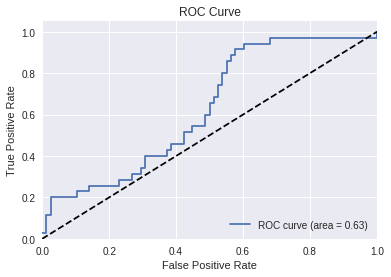

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.588 (+/- 0.059)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.630


In [63]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [64]:
logreg_tfidf_df = full_test_df.copy()

0    35
Name: y_pred, dtype: int64

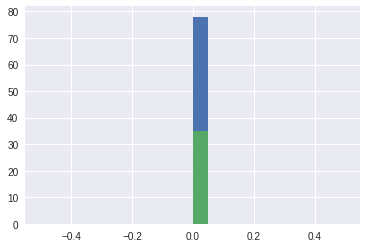

In [65]:
logreg_tfidf_df[logreg_tfidf_df.y_test == 0].y_pred.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

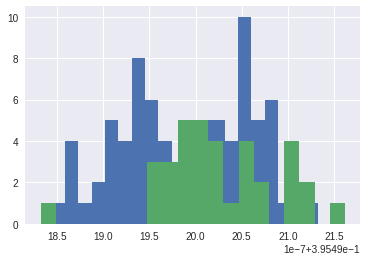

In [66]:
logreg_tfidf_df[logreg_tfidf_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [67]:
logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg_tfidf_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_tfidf_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_tfidf_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(logreg_tfidf_df.loc[i,'string'],'\n')
    
for id_subset in logreg_tfidf_df.sample_id[(logreg_tfidf_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
20,(depuis 2007) : vacant,1,1,0,0.395492,22.0,6.0
11,patrick cousot (né le 3 décembre 1948) est i...,1,1,0,0.395492,117.0,23.0
24,"compte tenu de sa très forte notoriété, l'entr...",1,1,0,0.395492,90.0,20.0
21,de nombreux artistes importants ont participé ...,1,1,0,0.395492,1049.0,207.0
7,ĉu vi demandis vian patron? = as-tu demandé ...,1,1,0,0.395492,418.0,103.0
26,créé au lendemain de la seconde guerre mondial...,1,1,0,0.395492,387.0,69.0
25,"très positionnel exploite de micro-avantages, ...",1,1,0,0.395492,69.0,14.0
10,le territoire communal est desservi par la lig...,1,1,0,0.395492,144.0,31.0
13,le union atletico de maracaibo est un club d...,1,1,0,0.395492,86.0,15.0
16,le toulouse blagnac hockey club est un club ...,1,1,0,0.395492,237.0,50.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


Mean length of detected positive scores (character-wise and token-wise)

In [68]:
logreg_tfidf_df.len[(dt_bow_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].mean()
logreg_tfidf_df.len_tok[(dt_bow_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].mean()

nan

nan

#### Decision tree classifier

In [69]:
clf = DecisionTreeClassifier(criterion='entropy', splitter='random')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

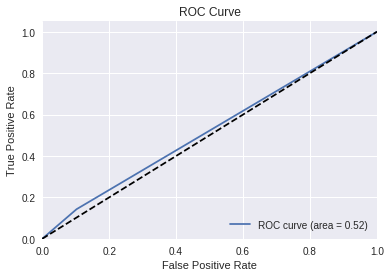

,score
precision,0.387 (+/- 0.101)
recall,0.250 (+/- 0.047)
f1,0.299 (+/- 0.100)
roc_auc,0.514 (+/- 0.033)


,test_score
precision,0.385
recall,0.143
f1,0.208
roc_auc,0.520


In [70]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [71]:
dt_tfidf_df = full_test_df.copy()

0    30
1     5
Name: y_pred, dtype: int64

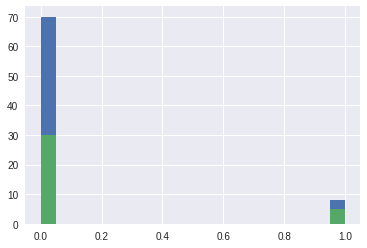

In [72]:
dt_tfidf_df[dt_tfidf_df.incoherence == 0].y_pred.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.incoherence == 1].y_pred.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

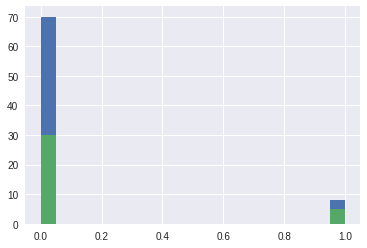

In [73]:
dt_tfidf_df[dt_tfidf_df.incoherence == 0].y_pred_proba.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.incoherence == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [74]:
dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt_tfidf_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(dt_tfidf_df.loc[i,'string'],'\n')
    
for id_subset in dt_tfidf_df.sample_id[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
34,cette abside est surmontée d'une très belle fr...,1,1,1,1.0,364.0,72.0
33,sa première scène dans la série concerne un éc...,1,1,1,1.0,811.0,170.0
21,de nombreux artistes importants ont participé ...,1,1,1,1.0,1049.0,207.0
24,"compte tenu de sa très forte notoriété, l'entr...",1,1,1,1.0,90.0,20.0
11,patrick cousot (né le 3 décembre 1948) est i...,1,1,1,1.0,117.0,23.0
25,"très positionnel exploite de micro-avantages, ...",1,1,0,0.0,69.0,14.0
20,(depuis 2007) : vacant,1,1,0,0.0,22.0,6.0
22,"marth est une princesse de taille normale, ell...",1,1,0,0.0,413.0,88.0
23,alles fühlt des liebe freuden (littéralement...,1,1,0,0.0,220.0,44.0
26,créé au lendemain de la seconde guerre mondial...,1,1,0,0.0,387.0,69.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
11,patrick cousot (né le 3 décembre 1948) est i...,1,1,1,1.0,117.0,23.0
21,de nombreux artistes importants ont participé ...,1,1,1,1.0,1049.0,207.0
24,"compte tenu de sa très forte notoriété, l'entr...",1,1,1,1.0,90.0,20.0
33,sa première scène dans la série concerne un éc...,1,1,1,1.0,811.0,170.0
34,cette abside est surmontée d'une très belle fr...,1,1,1,1.0,364.0,72.0


 patrick cousot  (né le 3 décembre 1948) est informaticien français, professeur à l'école normale supérieure à paris. 

de nombreux artistes importants ont participé depuis près de 50 ans à la biennale de paris : marina abramovic, vito acconci, karen andreassian, le collectif au travail/at work, john m. armleder, joseph beuys, gary bigot, alighiero boetti, microcollection, christian boltanski, thierry boutonnier, georges braque, florian brochec, daniel buren, michel chevalier, coum transmissions (genesis p-orridge et cosey fanni tutti), olivier darné, francois deck, bernard delville, marcel duchamp, sabine falk, jean baptiste farkas, dominic gagnon, gilbert and george, dan graham, yves klein, joseph kosuth, karine lebrun, andré éric létourneau, gordon matta-clark, ricardo mbarkho, mario merz, henri michaux, orlan, nam june paik, ostsa, giulio paolini, pablo picasso, michelangelo pistoletto, robert rauschenberg, hubert renard, paul robert, saint thomas l'imposteur, nana petzet, that's p

Mean length of detected positive scores (character-wise and token-wise)

In [75]:
dt_tfidf_df.len[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].mean()
dt_tfidf_df.len_tok[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].mean()

486.2

98.4

## Method 3: Mean vectors

Function for getting mean vector of each string

In [76]:
def w2v_extractor(df, model):
    
    token_list = []
    sentence_list = []
    
    for i in range(0, df.shape[0]): # for each string
        g = 0
        for token in re.findall(string_pattern, df.loc[i,'string']): # for each token of the string
            g += 1
            if token in model.wv.vocab:
                token_list.append(np.reshape(model.wv.word_vec(token), (1, model.vector_size)))
                
            else:
                continue
        
        string_matrix = np.vstack(token_list)
        
        string_average = string_matrix.mean(axis=0)
        
        sentence_list.append(string_average)
        token_list = []
    
    string_ave_matrix = np.vstack(sentence_list)
    
    list_col = [] # generate columns labels for each of the dimensions
    for i in range(0, model.vector_size):
        list_col.append('dim_{}'.format(i))

    dim_df = pd.DataFrame(string_ave_matrix)
    dim_df.columns = list_col
    
    return dim_df

### 3.1 Vector size 100

In [135]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')

dim_df_train = w2v_extractor(df_train, model)
dim_df_test = w2v_extractor(df_test, model)

temp_df_train = pd.concat([df_train.copy(), dim_df_train], axis=1)
temp_df_test = pd.concat([df_test.copy(), dim_df_test], axis=1)

X_train = temp_df_train[temp_df_train.columns[-model.vector_size:]].values.copy()
X_test = temp_df_test[temp_df_test.columns[-model.vector_size:]].values.copy()

y_train = temp_df_train.incoherence.values.copy()
y_test = temp_df_test.incoherence.values.copy()

#### Logistic regression

In [139]:
clf = LogisticRegression(solver='sag', n_jobs=-1)#, C=0.000000001)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


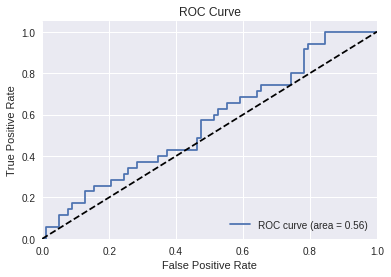

100

,score
precision,0.347 (+/- 0.166)
recall,0.056 (+/- 0.031)
f1,0.073 (+/- 0.073)
roc_auc,0.468 (+/- 0.089)


,test_score
precision,0.667
recall,0.057
f1,0.105
roc_auc,0.562


In [140]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [141]:
logreg100_mean_df = full_test_df.copy()

0    33
1     2
Name: y_pred, dtype: int64

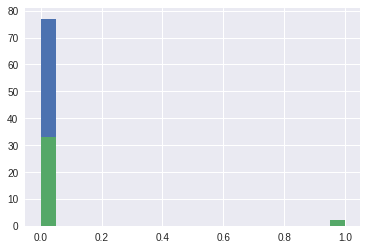

In [142]:
logreg100_mean_df[logreg100_mean_df.y_test == 0].y_pred.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

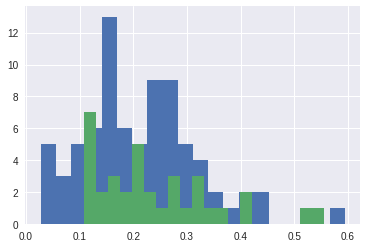

In [143]:
logreg100_mean_df[logreg100_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [144]:
logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg100_mean_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(logreg100_mean_df.loc[i,'string'],'\n')
    
for id_subset in logreg100_mean_df.sample_id[(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
20,(depuis 2007) : vacant,1,1,1,0.555410,22.0,6.0
7,ĉu vi demandis vian patron? = as-tu demandé ...,1,1,1,0.511842,418.0,103.0
11,patrick cousot (né le 3 décembre 1948) est i...,1,1,0,0.408944,117.0,23.0
27,l alphabet de cumae est une variante occident...,1,1,0,0.406654,441.0,95.0
17,"arrivé tardivement dans l'émission, ben effect...",1,1,0,0.364529,509.0,109.0
26,créé au lendemain de la seconde guerre mondial...,1,1,0,0.347966,387.0,69.0
21,de nombreux artistes importants ont participé ...,1,1,0,0.329558,1049.0,207.0
8,"pour une nouvelle franchise, le jeu a réalisé ...",1,1,0,0.326867,171.0,38.0
6,il est classé seizième meilleur film de tous l...,1,1,0,0.314774,220.0,54.0
14,"parmi les rescapés, le mieux préservé est le ...",1,1,0,0.288529,261.0,61.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
20,(depuis 2007) : vacant,1,1,1,0.555410,22.0,6.0
7,ĉu vi demandis vian patron? = as-tu demandé ...,1,1,1,0.511842,418.0,103.0


(depuis 2007) : vacant 

 ĉu vi demandis vian patron?  = as-tu demandé à un de tes parents? (à l'un ou à l'autre)  ĉu vi demandis vian patriĉon/virpatron?  = as-tu demandé à ton père?  ĉu vi demandis al via patrino?  = as-tu demandé à ta mère? le fait que le féminin se forme à partir du masculin en mettant -in-, est en plus une bonne préparation à l'étude de l'allemand où l'on retrouve la même marque.  ex: renard  fuchs  renarde  füchs in  

comparison link: 	 https://fr.wikipedia.org/w/index.php?diff=8846908&oldid=8845928 

comparison link: 	 https://fr.wikipedia.org/w/index.php?diff=27128712&oldid=26863952 



#### Decision tree classifier

In [84]:
clf = DecisionTreeClassifier()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

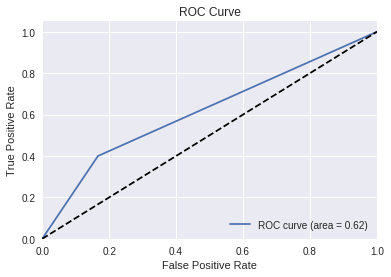

100

,score
precision,0.374 (+/- 0.061)
recall,0.278 (+/- 0.098)
f1,0.286 (+/- 0.090)
roc_auc,0.610 (+/- 0.040)


,test_score
precision,0.519
recall,0.400
f1,0.452
roc_auc,0.617


In [85]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [86]:
dt100_mean_df = full_test_df.copy()

0    21
1    14
Name: y_pred, dtype: int64

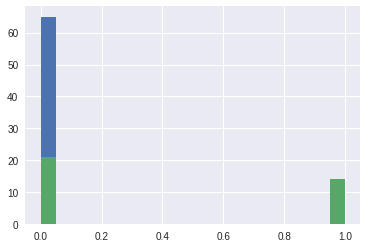

In [87]:
dt100_mean_df[dt100_mean_df.y_test == 0].y_pred.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

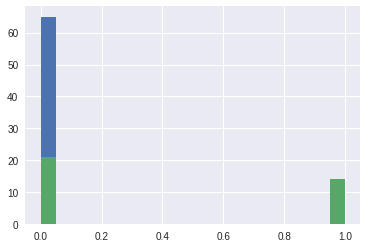

In [88]:
dt100_mean_df[dt100_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [89]:
dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt100_mean_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(dt100_mean_df.loc[i,'string'],'\n')
    
for id_subset in dt100_mean_df.sample_id[(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,on désigne par algorithmique ou algorithmie...,1,1,1,1.0,357.0,63.0
12,lorsque shenron a exaucé le vœu de la personne...,1,1,1,1.0,249.0,50.0
20,(depuis 2007) : vacant,1,1,1,1.0,22.0,6.0
18,"de 2006 à 2009, il conçoit et présente plusieu...",1,1,1,1.0,315.0,67.0
24,"compte tenu de sa très forte notoriété, l'entr...",1,1,1,1.0,90.0,20.0
16,le toulouse blagnac hockey club est un club ...,1,1,1,1.0,237.0,50.0
15,l école des hautes études commerciales du nord...,1,1,1,1.0,738.0,140.0
25,"très positionnel exploite de micro-avantages, ...",1,1,1,1.0,69.0,14.0
13,le union atletico de maracaibo est un club d...,1,1,1,1.0,86.0,15.0
21,de nombreux artistes importants ont participé ...,1,1,1,1.0,1049.0,207.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,on désigne par algorithmique ou algorithmie...,1,1,1,1.0,357.0,63.0
8,"pour une nouvelle franchise, le jeu a réalisé ...",1,1,1,1.0,171.0,38.0
9,"cette institution, premier lycée de filles par...",1,1,1,1.0,655.0,129.0
12,lorsque shenron a exaucé le vœu de la personne...,1,1,1,1.0,249.0,50.0
13,le union atletico de maracaibo est un club d...,1,1,1,1.0,86.0,15.0
15,l école des hautes études commerciales du nord...,1,1,1,1.0,738.0,140.0
16,le toulouse blagnac hockey club est un club ...,1,1,1,1.0,237.0,50.0
18,"de 2006 à 2009, il conçoit et présente plusieu...",1,1,1,1.0,315.0,67.0
20,(depuis 2007) : vacant,1,1,1,1.0,22.0,6.0
21,de nombreux artistes importants ont participé ...,1,1,1,1.0,1049.0,207.0


on désigne par  algorithmique  ou  algorithmie  l'ensemble des activités logiques qui relèvent  des  algorithmes . le mot vient du nom du mathématicien perse al khuwarizmi, qui, au ixe siècle écrivit le premier ouvrage systématique sur la solution des équations linéaires et quadratiques. dans le cas général, l'algorithmique s'effectue au moyen de calculs. 

pour une nouvelle franchise, le jeu a réalisé le meilleur démarrage sur consoles xbox  . il s'est pour le moment vendu à plus de 5.6 millions d'exemplaires dans le monde.  

cette institution, premier lycée de filles parisien, a été fondée en 1892 dans des bâtiments datant du  xviii e  pour préparer ses élèves au concours de l'école normale supérieure. son nom est celui de fénelon, archevêque de cambrai et écrivain français qui avait traité dans ses écrits le sujet de l'éducation des femmes. il est devenu mixte en 1979 et avant 1972 pour les classes préparatoires. encore aujourd'hui, le lycée fénelon demeure l'un des meilleurs de la

### 3.2 Vector size 300

In [90]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')

dim_df_train = w2v_extractor(df_train, model)
dim_df_test = w2v_extractor(df_test, model)

temp_df_train = pd.concat([df_train.copy(), dim_df_train], axis=1)
temp_df_test = pd.concat([df_test.copy(), dim_df_test], axis=1)

X_train = temp_df_train[temp_df_train.columns[-model.vector_size:]].values.copy()
X_test = temp_df_test[temp_df_test.columns[-model.vector_size:]].values.copy()

y_train = temp_df_train.incoherence.values.copy()
y_test = temp_df_test.incoherence.values.copy()

#### Logistic regression

In [91]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.000000001)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


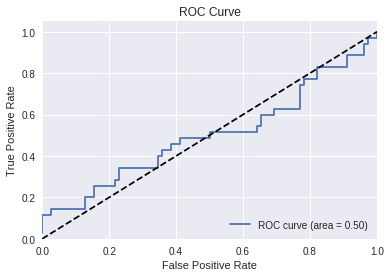

300

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.491 (+/- 0.054)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.501


In [92]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [93]:
logreg300_mean_df = full_test_df.copy()

0    35
Name: y_pred, dtype: int64

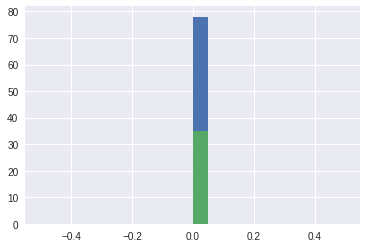

In [94]:
logreg300_mean_df[logreg300_mean_df.y_test == 0].y_pred.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

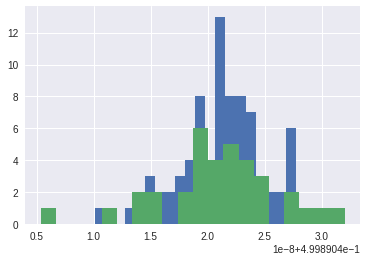

In [95]:
logreg300_mean_df[logreg300_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [96]:
logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg300_mean_df.y_test==1].sort_values('y_pred_proba', ascending=True)
logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(logreg300_mean_df.loc[i,'string'],'\n')
    
for id_subset in logreg300_mean_df.sample_id[(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
20,(depuis 2007) : vacant,1,1,0,0.49989,22.0,6.0
11,patrick cousot (né le 3 décembre 1948) est i...,1,1,0,0.49989,117.0,23.0
6,il est classé seizième meilleur film de tous l...,1,1,0,0.49989,220.0,54.0
18,"de 2006 à 2009, il conçoit et présente plusieu...",1,1,0,0.49989,315.0,67.0
17,"arrivé tardivement dans l'émission, ben effect...",1,1,0,0.49989,509.0,109.0
3,ce syndicat a beaucoup fait jaser de lui lors ...,1,1,0,0.49989,481.0,94.0
26,créé au lendemain de la seconde guerre mondial...,1,1,0,0.49989,387.0,69.0
9,"cette institution, premier lycée de filles par...",1,1,0,0.49989,655.0,129.0
23,alles fühlt des liebe freuden (littéralement...,1,1,0,0.49989,220.0,44.0
15,l école des hautes études commerciales du nord...,1,1,0,0.49989,738.0,140.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision Tree classifier

In [97]:
clf = DecisionTreeClassifier()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

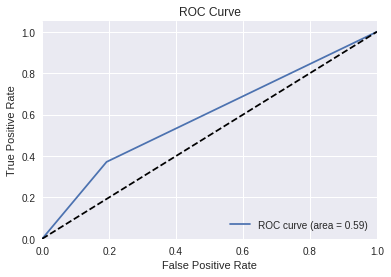

300

,score
precision,0.330 (+/- 0.033)
recall,0.352 (+/- 0.133)
f1,0.376 (+/- 0.046)
roc_auc,0.532 (+/- 0.062)


,test_score
precision,0.464
recall,0.371
f1,0.413
roc_auc,0.590


In [98]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [99]:
dt300_mean_df = full_test_df.copy()

0    22
1    13
Name: y_pred, dtype: int64

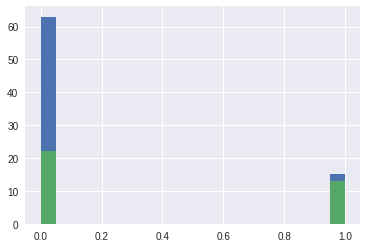

In [100]:
dt300_mean_df[dt300_mean_df.y_test == 0].y_pred.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

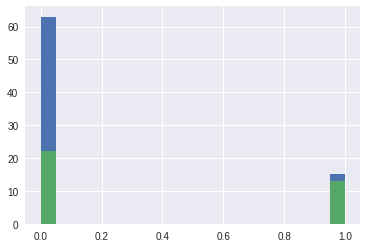

In [101]:
dt300_mean_df[dt300_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [102]:
dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt300_mean_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(dt300_mean_df.loc[i,'string'],'\n')
    
for id_subset in dt300_mean_df.sample_id[(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,on désigne par algorithmique ou algorithmie...,1,1,0,0.0,357.0,63.0
31,l'histoire politique est avant tout bien connu...,1,1,0,0.0,304.0,58.0
30,exemple le plus emblématique de l'orientalisme...,1,1,0,0.0,588.0,112.0
28,"marilou est une fille belle, mais manipulatri...",1,1,0,0.0,232.0,43.0
26,créé au lendemain de la seconde guerre mondial...,1,1,0,0.0,387.0,69.0
22,"marth est une princesse de taille normale, ell...",1,1,0,0.0,413.0,88.0
21,de nombreux artistes importants ont participé ...,1,1,0,0.0,1049.0,207.0
20,(depuis 2007) : vacant,1,1,0,0.0,22.0,6.0
18,"de 2006 à 2009, il conçoit et présente plusieu...",1,1,0,0.0,315.0,67.0
33,sa première scène dans la série concerne un éc...,1,1,0,0.0,811.0,170.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
2,la tomate ( solanum lycopersicum l.) est un...,1,1,1,1.0,587.0,118.0
3,ce syndicat a beaucoup fait jaser de lui lors ...,1,1,1,1.0,481.0,94.0
4,"en 2002, elle fait partie de la distribution d...",1,1,1,1.0,423.0,86.0
8,"pour une nouvelle franchise, le jeu a réalisé ...",1,1,1,1.0,171.0,38.0
11,patrick cousot (né le 3 décembre 1948) est i...,1,1,1,1.0,117.0,23.0
16,le toulouse blagnac hockey club est un club ...,1,1,1,1.0,237.0,50.0
19,bien qu'elles soient souvent négligées ou redo...,1,1,1,1.0,589.0,107.0
23,alles fühlt des liebe freuden (littéralement...,1,1,1,1.0,220.0,44.0
24,"compte tenu de sa très forte notoriété, l'entr...",1,1,1,1.0,90.0,20.0
25,"très positionnel exploite de micro-avantages, ...",1,1,1,1.0,69.0,14.0


la  tomate  ( solanum lycopersicum  l.) est une espèce de plantes herbacées de la famille des solanacées, originaire du nord-ouest de l'amérique du sud , largement cultivée pour son fruit climactérique. le terme désigne aussi ce fruit charnu, qui est l'un des légumes  les plus importants dans l'alimentation humaine et qui se consomme frais ou transformé. la tomate est devenue un élément incontournable de la gastronomie de nombreux pays, et tout particulièrement en grèce ( 72 kg  par habitant/par an) , italie, espagne et france (pour ce qui concerne les pays de l'union européenne). 

ce syndicat a beaucoup fait jaser de lui lors de la récente grève étudiante de 2005.  la fecq et la feuq, son pendant universitaire, furent en effet les deux seuls syndicats étudiants autorisés à s'asseoir à la table de négociations en compagnie du ministre de l'éducation du québec, jean-marc fournier.  cette exclusivité fut largement critiqué, tant par l'association pour une solidarité syndicale étudiante 

## Method 4: skig-gram model

In [103]:
def scores_generator(df_train, df_test, pair_fn):
    
    df_test_temp = df_test.copy()
    df_test_temp = df_test_temp.reset_index()

    df_scores = pd.DataFrame(index=df_train.index, columns=['score'])
    df_scores_test = pd.DataFrame(index=df_test_temp.index, columns=['score'])

    for i in range(0, df_train.shape[0]):
        df_scores.loc[i,'string'] = df_train.loc[i,'string']
        df_scores.loc[i,'score'] = score_sentence_sg(pair_fn, model, re.findall(string_pattern, df_train.loc[i,'string']))
        
    X_train = df_scores.score
    y_train = df_train.incoherence
    
    for i in range(0, df_test_temp.shape[0]):
        df_scores_test.loc[i,'string'] = df_test_temp.loc[i,'string']
        df_scores_test.loc[i,'score'] = score_sentence_sg(pair_fn, model, re.findall(string_pattern, df_test_temp.loc[i,'string']))
        
    X_test = df_scores_test.score
    y_test = df_test_temp.incoherence
    
    return df_scores, X_train, y_train, df_scores_test, X_test, y_test

In [104]:
def score_sentence_sg(score_sg_fn, model, sentence, work=None):
    """
    Obtain likelihood score for a single sentence in a fitted skip-gram representaion.

    The sentence is a list of Vocab objects (or None, when the corresponding
    word is not in the vocabulary). Called internally from `Word2Vec.score()`.

    This is the non-optimized, Python version. If you have cython installed, gensim
    will use the optimized version from word2vec_inner instead.
    
    """

    log_prob_sentence = 0.0
    if model.negative:
        raise RuntimeError("scoring is only available for HS=True")

    word_vocabs = [model.wv.vocab[w] for w in sentence if w in model.wv.vocab]
    for pos, word in enumerate(word_vocabs):
        if word is None:
            continue  # OOV word in the input sentence => skip

        # now go over all words from the window, predicting each one in turn
        start = max(0, pos - model.window)
        for pos2, word2 in enumerate(word_vocabs[start : pos + model.window + 1], start):
            # don't train on OOV words and on the `word` itself
            if word2 is not None and pos2 != pos:
                log_prob_sentence += score_sg_fn(model, word, word2)

    return log_prob_sentence


def score_sg_pair_original(model, word, word2):
    l1 = model.wv.syn0[word2.index]
    l2a = deepcopy(model.syn1[word.point])  # 2d matrix, codelen x layer1_size
    sgn = (-1.0)**word.code  # ch function, 0-> 1, 1 -> -1
    lprob = -np.log(1.0 + np.exp(-sgn*np.dot(l1, l2a.T)))
    return sum(lprob)

def score_sg_pair(model, word, word2):
    #print(word, word2)
    l1 = model.wv.syn0[word2.index]
    print('a >', word.point.shape, word.code.shape)
    l2 = deepcopy(model.syn1[word.point])  # 2d matrix, codelen x layer1_size

    #assert l1.shape == l2.shape
    lprob = l2 * l1
    print('b >', lprob.shape)
    return lprob

### 4.1 Vector size 100

In [105]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')
df_scores, X_train, y_train, df_scores_test, X_test, y_test = scores_generator(df_train, df_test, score_sg_pair_original)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


#### Logistic regression

In [106]:
clf = LogisticRegression(C=0.00001)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

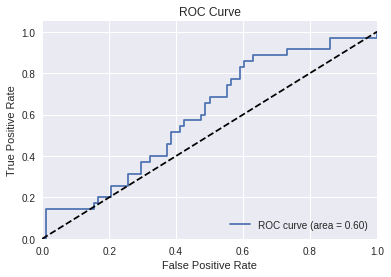

100

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.568 (+/- 0.053)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.599


In [107]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [108]:
logreg100_sg_df = full_test_df.copy()

0    35
Name: y_pred, dtype: int64

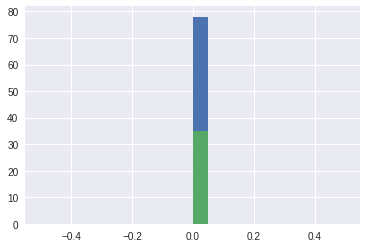

In [109]:
logreg100_sg_df[logreg100_sg_df.y_test == 0].y_pred.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

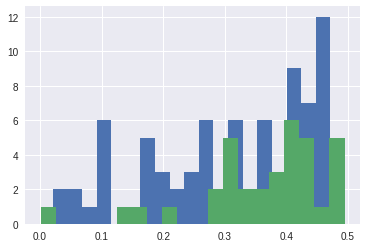

In [110]:
logreg100_sg_df[logreg100_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [111]:
logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg100_sg_df.y_test==1].sort_values('y_pred_proba', ascending=True)
logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(logreg100_sg_df.loc[i,'string'],'\n')
    
for id_subset in logreg100_sg_df.sample_id[(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
1,"le 29 mai 1958, rené coty appelle le général d...",1,1,0,0.001055,4665.0,942.0
29,"dans ce cas de dressage, le dressage s’opère l...",1,1,0,0.127119,1168.0,284.0
21,de nombreux artistes importants ont participé ...,1,1,0,0.168188,1049.0,207.0
33,sa première scène dans la série concerne un éc...,1,1,0,0.222318,811.0,170.0
15,l école des hautes études commerciales du nord...,1,1,0,0.276334,738.0,140.0
9,"cette institution, premier lycée de filles par...",1,1,0,0.288698,655.0,129.0
19,bien qu'elles soient souvent négligées ou redo...,1,1,0,0.309435,589.0,107.0
17,"arrivé tardivement dans l'émission, ben effect...",1,1,0,0.312124,509.0,109.0
30,exemple le plus emblématique de l'orientalisme...,1,1,0,0.314684,588.0,112.0
2,la tomate ( solanum lycopersicum l.) est un...,1,1,0,0.316544,587.0,118.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision tree classifier

In [112]:
clf = DecisionTreeClassifier(max_depth=1)#,criterion='entropy')#, splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

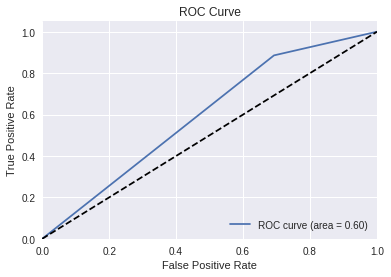

100

,score
precision,0.000 (+/- 0.000)
recall,0.009 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.514 (+/- 0.027)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.597


In [113]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [114]:
dt100_sg_df = full_test_df.copy()

0    35
Name: y_pred, dtype: int64

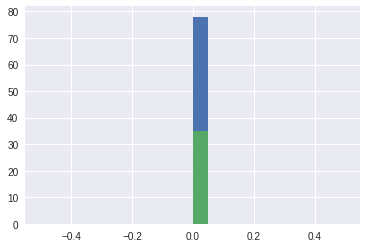

In [115]:
dt100_sg_df[dt100_sg_df.y_test == 0].y_pred.hist(bins=20)
dt100_sg_df[dt100_sg_df.y_test == 1].y_pred.hist(bins=20)
dt100_sg_df[dt100_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

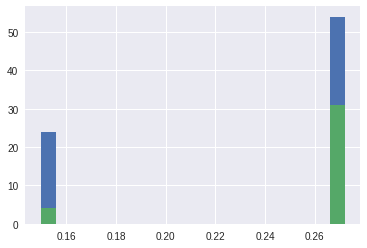

In [116]:
dt100_sg_df[dt100_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
dt100_sg_df[dt100_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [117]:
dt100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt100_sg_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_sg_df.y_test == 1)&(dt100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_sg_df.y_test == 1)&(dt100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(dt100_sg_df.loc[i,'string'],'\n')
    
for id_subset in dt100_sg_df.sample_id[(dt100_sg_df.y_test == 1)&(dt100_sg_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,on désigne par algorithmique ou algorithmie...,1,1,0,0.272171,357.0,63.0
16,le toulouse blagnac hockey club est un club ...,1,1,0,0.272171,237.0,50.0
32,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.272171,187.0,43.0
31,l'histoire politique est avant tout bien connu...,1,1,0,0.272171,304.0,58.0
30,exemple le plus emblématique de l'orientalisme...,1,1,0,0.272171,588.0,112.0
28,"marilou est une fille belle, mais manipulatri...",1,1,0,0.272171,232.0,43.0
27,l alphabet de cumae est une variante occident...,1,1,0,0.272171,441.0,95.0
26,créé au lendemain de la seconde guerre mondial...,1,1,0,0.272171,387.0,69.0
25,"très positionnel exploite de micro-avantages, ...",1,1,0,0.272171,69.0,14.0
24,"compte tenu de sa très forte notoriété, l'entr...",1,1,0,0.272171,90.0,20.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


### 4.2 Vector size 300

In [118]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')
df_scores, X_train, y_train, df_scores_test, X_test, y_test = scores_generator(df_train, df_test, score_sg_pair_original)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


#### Logistic regression

In [119]:
clf = LogisticRegression()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

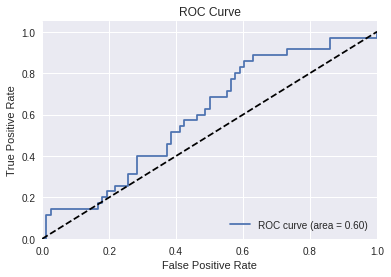

300

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.575 (+/- 0.048)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.600


In [120]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [121]:
logreg300_sg_df = full_test_df.copy()

0    35
Name: y_pred, dtype: int64

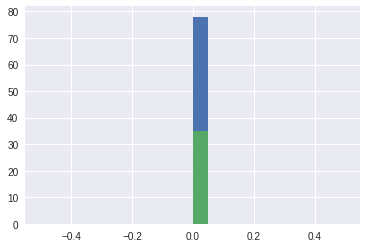

In [122]:
logreg300_sg_df[logreg300_sg_df.y_test == 0].y_pred.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

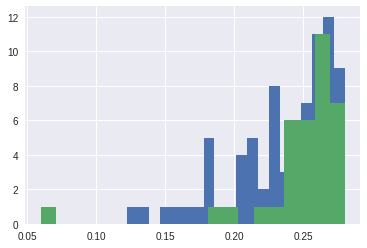

In [123]:
logreg300_sg_df[logreg300_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [124]:
logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg300_sg_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(logreg300_sg_df.loc[i,'string'],'\n')
    
for id_subset in logreg300_sg_df.sample_id[(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
20,(depuis 2007) : vacant,1,1,0,0.280055,22.0,6.0
25,"très positionnel exploite de micro-avantages, ...",1,1,0,0.276765,69.0,14.0
13,le union atletico de maracaibo est un club d...,1,1,0,0.276356,86.0,15.0
24,"compte tenu de sa très forte notoriété, l'entr...",1,1,0,0.275324,90.0,20.0
11,patrick cousot (né le 3 décembre 1948) est i...,1,1,0,0.274742,117.0,23.0
10,le territoire communal est desservi par la lig...,1,1,0,0.271021,144.0,31.0
8,"pour une nouvelle franchise, le jeu a réalisé ...",1,1,0,0.269195,171.0,38.0
32,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.267498,187.0,43.0
23,alles fühlt des liebe freuden (littéralement...,1,1,0,0.265671,220.0,44.0
16,le toulouse blagnac hockey club est un club ...,1,1,0,0.265053,237.0,50.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision tree

In [125]:
clf = DecisionTreeClassifier()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

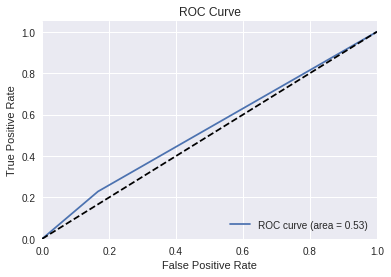

300

,score
precision,0.318 (+/- 0.088)
recall,0.398 (+/- 0.055)
f1,0.385 (+/- 0.080)
roc_auc,0.588 (+/- 0.038)


,test_score
precision,0.381
recall,0.229
f1,0.286
roc_auc,0.531


In [126]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [127]:
dt300_sg_df = full_test_df.copy()

0    27
1     8
Name: y_pred, dtype: int64

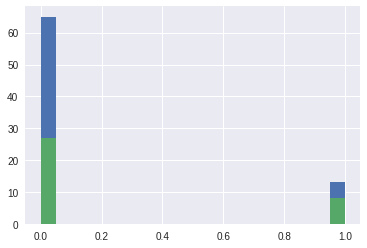

In [128]:
dt300_sg_df[dt300_sg_df.y_test == 0].y_pred.hist(bins=20)
dt300_sg_df[dt300_sg_df.y_test == 1].y_pred.hist(bins=20)
dt300_sg_df[dt300_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

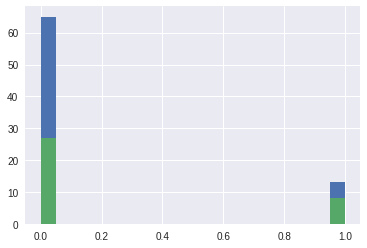

In [129]:
dt300_sg_df[dt300_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
dt300_sg_df[dt300_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [130]:
dt300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt300_sg_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_sg_df.y_test == 1)&(dt300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_sg_df.y_test == 1)&(dt300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(dt300_sg_df.loc[i,'string'],'\n')

for id_subset in dt300_sg_df.sample_id[(dt300_sg_df.y_test == 1)&(dt300_sg_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
17,"arrivé tardivement dans l'émission, ben effect...",1,1,1,1.0,509.0,109.0
9,"cette institution, premier lycée de filles par...",1,1,1,1.0,655.0,129.0
1,"le 29 mai 1958, rené coty appelle le général d...",1,1,1,1.0,4665.0,942.0
16,le toulouse blagnac hockey club est un club ...,1,1,1,1.0,237.0,50.0
26,créé au lendemain de la seconde guerre mondial...,1,1,1,1.0,387.0,69.0
20,(depuis 2007) : vacant,1,1,1,1.0,22.0,6.0
10,le territoire communal est desservi par la lig...,1,1,1,1.0,144.0,31.0
3,ce syndicat a beaucoup fait jaser de lui lors ...,1,1,1,1.0,481.0,94.0
29,"dans ce cas de dressage, le dressage s’opère l...",1,1,0,0.0,1168.0,284.0
28,"marilou est une fille belle, mais manipulatri...",1,1,0,0.0,232.0,43.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
1,"le 29 mai 1958, rené coty appelle le général d...",1,1,1,1.0,4665.0,942.0
3,ce syndicat a beaucoup fait jaser de lui lors ...,1,1,1,1.0,481.0,94.0
9,"cette institution, premier lycée de filles par...",1,1,1,1.0,655.0,129.0
10,le territoire communal est desservi par la lig...,1,1,1,1.0,144.0,31.0
16,le toulouse blagnac hockey club est un club ...,1,1,1,1.0,237.0,50.0
17,"arrivé tardivement dans l'émission, ben effect...",1,1,1,1.0,509.0,109.0
20,(depuis 2007) : vacant,1,1,1,1.0,22.0,6.0
26,créé au lendemain de la seconde guerre mondial...,1,1,1,1.0,387.0,69.0


le 29 mai 1958, rené coty appelle le général de gaulle, suite aux mouvements insurrectionnels menés par des partisans de l'algérie française et des gaullistes, les deux étiquettes n'étant pas exclusives. le 4 juin 1958, le général crie à alger le fameux « je vous ai compris » . la foule comprenant des pieds noirs et des musulmans croyant à la magie de ces mots, crièrent « vive l'algérie française » tout en ovationnant le discours . le surlendemain 6 juin, il crie  «vive l'algérie française!»  à mostaganem. le 16 septembre 1959 le choc fut donc brutal pour tous les européens, qui se réveillent en entendant le général de gaulle parler d'autodétermination. à partir de ces circonstances joseph ortiz crée le puissant fnf (front national français), mouvement nationaliste et activiste. de nombreux autres groupuscules activistes naissent ou renaissent pour s'insurger contre ce qu'ils considèrent comme l'infamie et déshonneur gaullien. le 24 janvier 1960, début des barricades avec la participat